In [143]:
import pandas as pd
import pyarrow

easy_data = pd.read_parquet("../data/super_easy/track2_data.parquet")
hard_data = pd.read_parquet("../data/hard/track2_data.parquet")
easy_move = pd.read_parquet("../data/super_easy/ground_truth.parquet")
med_data = pd.read_parquet("../data/medium/track2_data.parquet")
med_move = pd.read_parquet("../data/medium/ground_truth.parquet")
hard_move = pd.read_parquet("../data/hard/ground_truth.parquet")

In [82]:
import matplotlib.pyplot as plt

def plot_channel_spectrogram(df, channel_idx, fs=500, t_start=None, t_end=None):
    # Slice dataframe to time range (defaults to entire duration if None)
    subset = df.loc[t_start:t_end]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 1. Raw Trace
    ax1.plot(subset.index, subset[channel_idx], linewidth=0.5)
    ax1.set_title(f"Channel {channel_idx} Raw Trace")
    ax1.set_ylabel("Amplitude")
    
    # 2. Spectrogram
    # xextent aligns the spectrogram x-axis with the dataframe's time index
    ax2.specgram(subset[channel_idx], NFFT=256, Fs=fs, noverlap=128, cmap='jet',
                 xextent=[subset.index.min(), subset.index.max()])
    
    ax2.set_title("Spectrogram")
    ax2.set_ylabel("Frequency (Hz)")
    ax2.set_xlabel("Time (s)")
    
    plt.tight_layout()
    plt.show()

# Usage Examples:
# plot_channel_spectrogram(hard_data, 0)                  # Whole period
# plot_channel_spectrogram(hard_data, 0, t_start=10, t_end=15)  # 10s to 15s

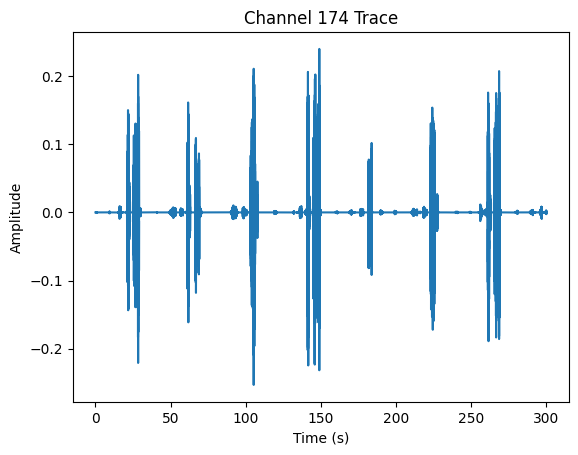

In [80]:
import matplotlib.pyplot as plt

# Replace 'data' with your actual variable name (e.g., easy_data or hard_data)
# This uses the 'time_s' index automatically for the x-axis
easy_data[174].plot(title="Channel 174 Trace", xlabel="Time (s)", ylabel="Amplitude")
plt.show()

/Users/songyangwang/repos/brainstorm-track2-public/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


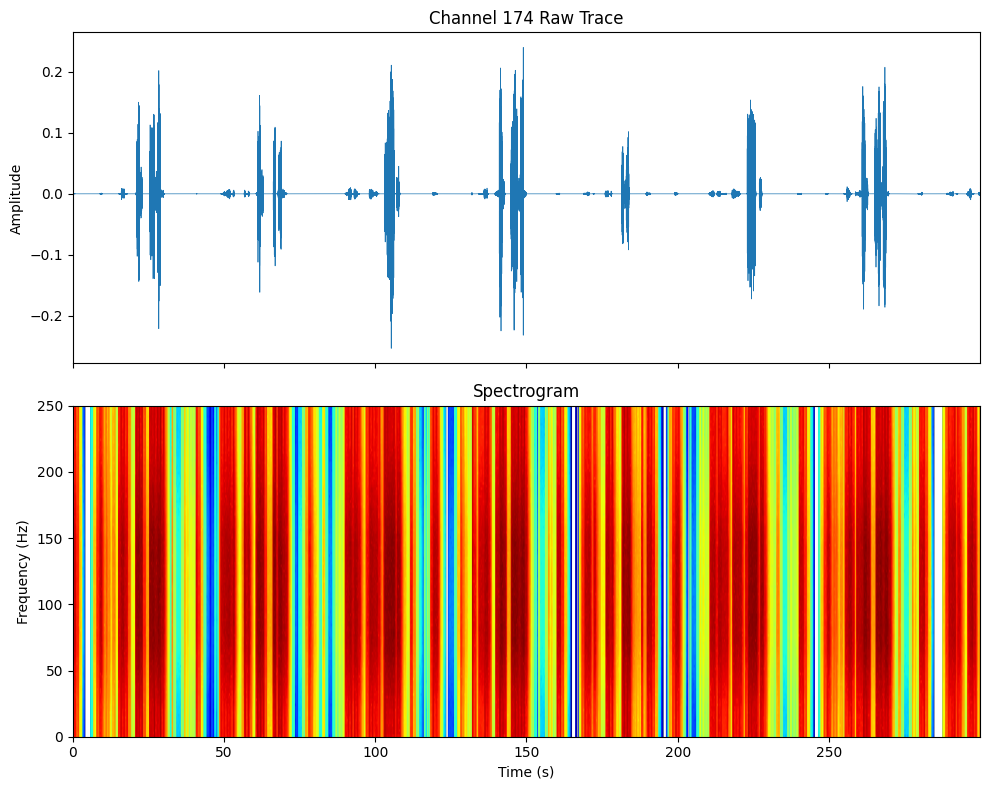

In [142]:
plot_channel_spectrogram(easy_data, 174)

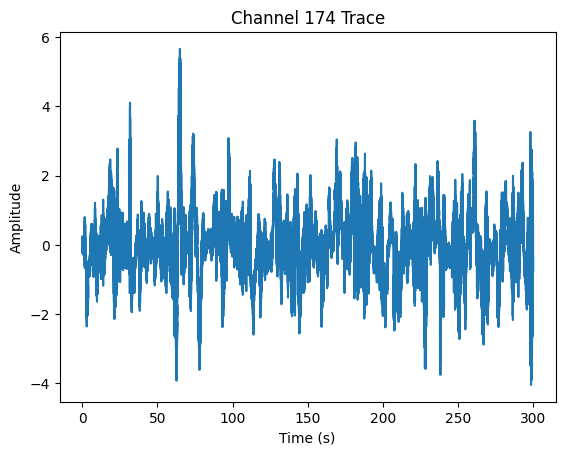

In [81]:
import matplotlib.pyplot as plt

# Replace 'data' with your actual variable name (e.g., easy_data or hard_data)
# This uses the 'time_s' index automatically for the x-axis
hard_data[174].plot(title="Channel 174 Trace", xlabel="Time (s)", ylabel="Amplitude")
plt.show()

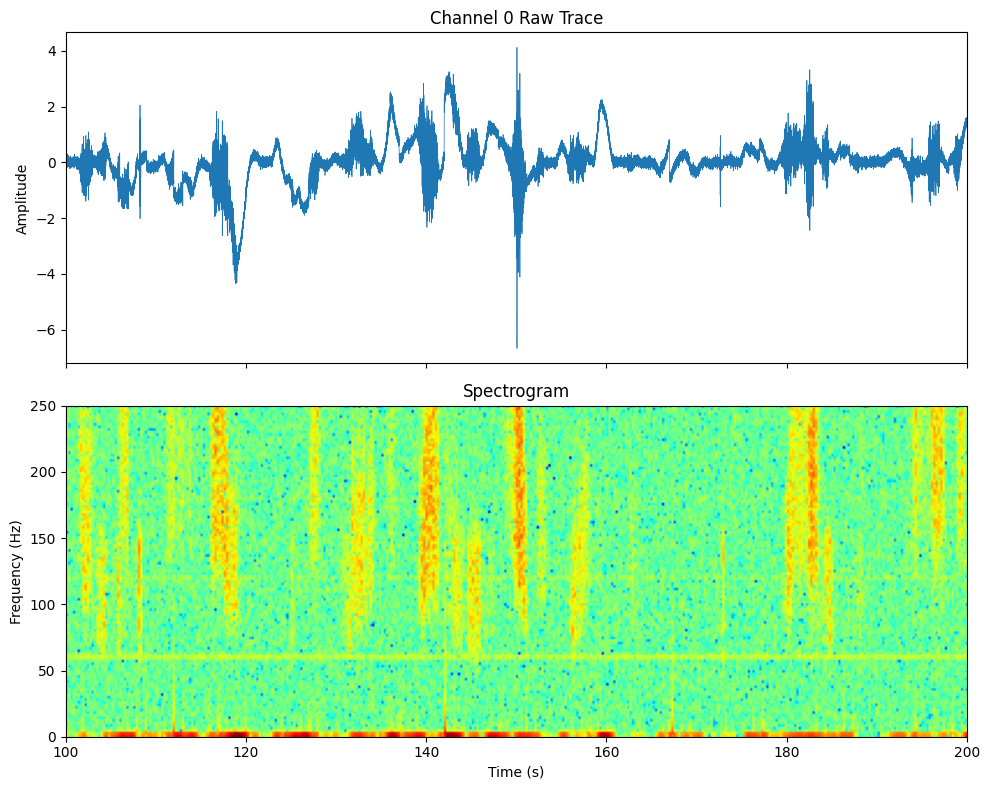

In [84]:
plot_channel_spectrogram(hard_data, 0, t_start=100, t_end=200)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

def visualize_preprocessing_steps(df, channel_idx=0, t_start=0, t_end=2, fs=500):
    """
    Visualizes the effect of Notch Filter and CAR on a single channel 
    in both Time and Frequency domains.
    """
    # --- Step 1: Capture Raw Data ---
    raw_sig = df.iloc[:, channel_idx]
    
    # --- Step 2: Apply Notch Filter & Capture ---
    b, a = signal.iirnotch(w0=60.0, Q=30.0, fs=fs)
    # Apply to whole dataframe to match your pipeline, or just this channel for speed
    filtered_matrix = signal.filtfilt(b, a, df.values, axis=0)
    df_notch = pd.DataFrame(filtered_matrix, index=df.index, columns=df.columns)
    notch_sig = df_notch.iloc[:, channel_idx]

    # --- Step 3: Apply CAR & Capture ---
    # Subtract average of all channels
    df_car = df_notch.sub(df_notch.mean(axis=1), axis=0)
    car_sig = df_car.iloc[:, channel_idx]

    # --- Step 4: Visualization ---
    fig, (ax_time, ax_freq) = plt.subplots(2, 1, figsize=(12, 10))
    
    # 4a. Time Domain Plot
    subset_slice = slice(int(t_start*fs), int(t_end*fs))
    times = df.index[subset_slice] if isinstance(df.index, (pd.Index, np.ndarray)) else np.arange(t_start, t_end, 1/fs)
    
    ax_time.plot(times, raw_sig.iloc[subset_slice], label='1. Raw', alpha=0.5, color='gray')
    ax_time.plot(times, notch_sig.iloc[subset_slice], label='2. After Notch (60Hz)', alpha=0.8, color='orange', linestyle='--')
    ax_time.plot(times, car_sig.iloc[subset_slice], label='3. After CAR', color='blue', linewidth=1.5)
    
    ax_time.set_title(f"Time Domain: Channel {df.columns[channel_idx]} ({t_start}-{t_end}s)")
    ax_time.set_ylabel("Amplitude")
    ax_time.set_xlabel("Time (s)")
    ax_time.legend(loc='upper right')
    ax_time.grid(True, alpha=0.3)

    # 4b. Frequency Domain Plot (PSD) using Welch's method
    # We use the whole signal (or a large chunk) for better frequency resolution
    # 4b. Frequency Domain Plot (PSD) using Welch's method
    # FIX: Add .values to convert Series to NumPy array
    freqs, psd_raw = signal.welch(raw_sig.values, fs=fs, nperseg=1024)
    _, psd_notch = signal.welch(notch_sig.values, fs=fs, nperseg=1024)
    _, psd_car = signal.welch(car_sig.values, fs=fs, nperseg=1024)

    ax_freq.semilogy(freqs, psd_raw, label='1. Raw', color='gray', alpha=0.5)
    ax_freq.semilogy(freqs, psd_notch, label='2. After Notch', color='orange', linestyle='--')
    ax_freq.semilogy(freqs, psd_car, label='3. After CAR', color='blue')
    
    ax_freq.set_title("Frequency Domain (Power Spectral Density)")
    ax_freq.set_xlabel("Frequency (Hz)")
    ax_freq.set_ylabel("Power/Frequency (dB/Hz)")
    ax_freq.set_xlim(0, 100)  # Zoom in on 0-100Hz to see the 60Hz notch clearly
    ax_freq.axvline(60, color='red', linestyle=':', alpha=0.5, label='60Hz Mains')
    ax_freq.legend()
    ax_freq.grid(True, which='both', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- Example Usage ---


In [55]:
from scipy import signal
import pandas as pd

def preprocess_signals(df, fs=500):
    """
    Applies Notch Filter (60Hz), Common Average Reference (CAR), and Linear Detrending.
    """
    # 1. Notch Filter (60 Hz)
    # Q=30 concentrates the filter narrowly around 60Hz to preserve other data
    b, a = signal.iirnotch(w0=60.0, Q=30.0, fs=fs)
    # filtfilt applies the filter forward and backward (zero-phase distortion)
    filtered_matrix = signal.filtfilt(b, a, df.values, axis=0)
    
    # Rebuild DataFrame to keep indices/columns safe
    df_clean = pd.DataFrame(filtered_matrix, index=df.index, columns=df.columns)

    # 2. Common Average Reference (CAR)
    # Subtract the average of all channels from every channel at each timepoint
    df_clean = df_clean.sub(df_clean.mean(axis=1), axis=0)

    # 3. Detrend
    # Remove linear trend from each channel
    # comment for now since it is not very important rn
    # df_clean[:] = signal.detrend(df_clean.values, axis=0, type='linear')
    
    return df_clean

# Usage:
# clean_data = preprocess_signals(hard_data)
# plot_channel_spectrogram(clean_data, 0)

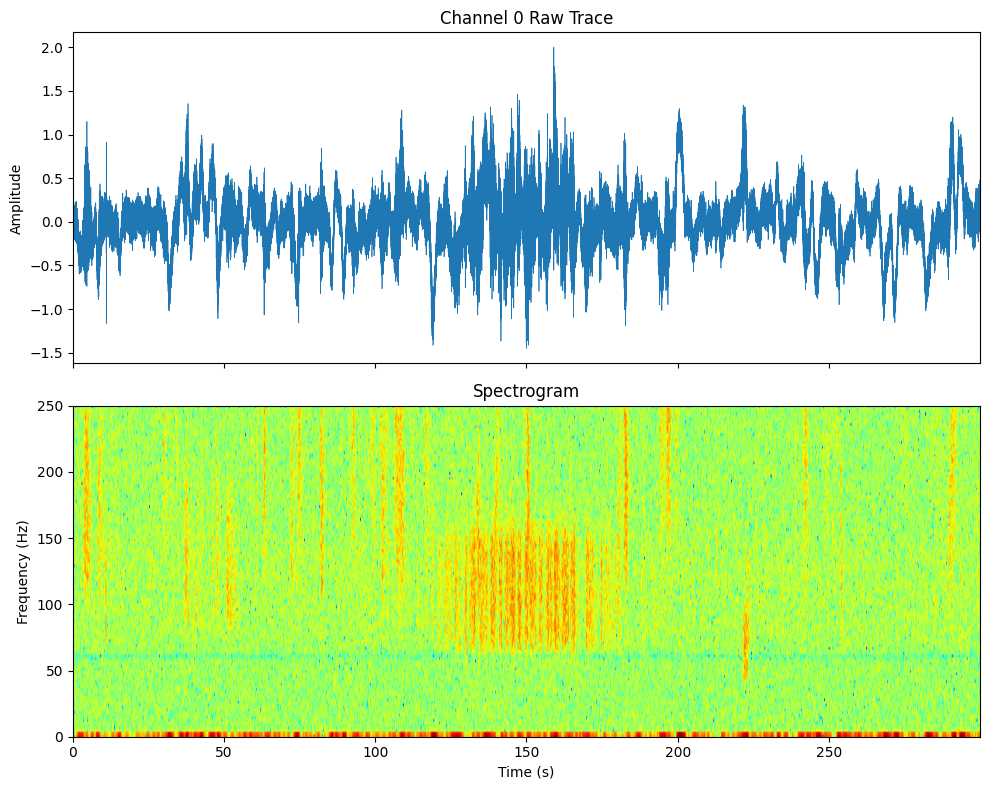

In [56]:
plot_channel_spectrogram(preprocess_signals(hard_data), 0)

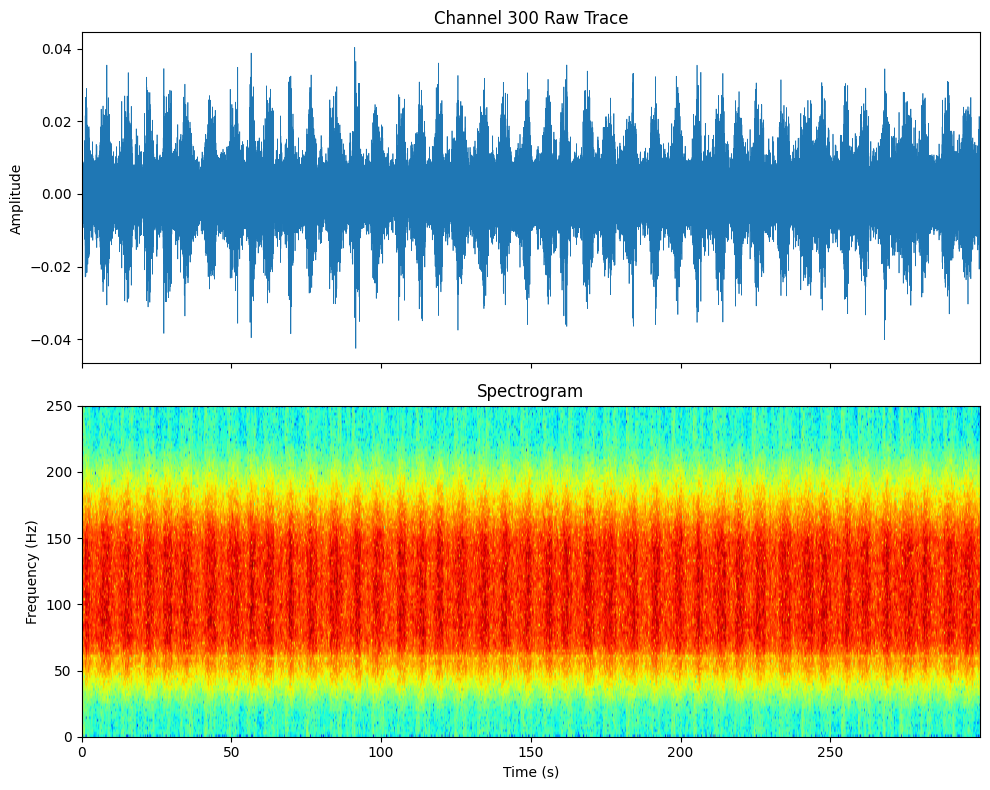

In [71]:
plot_channel_spectrogram(preprocess_signals(easy_data), 300)

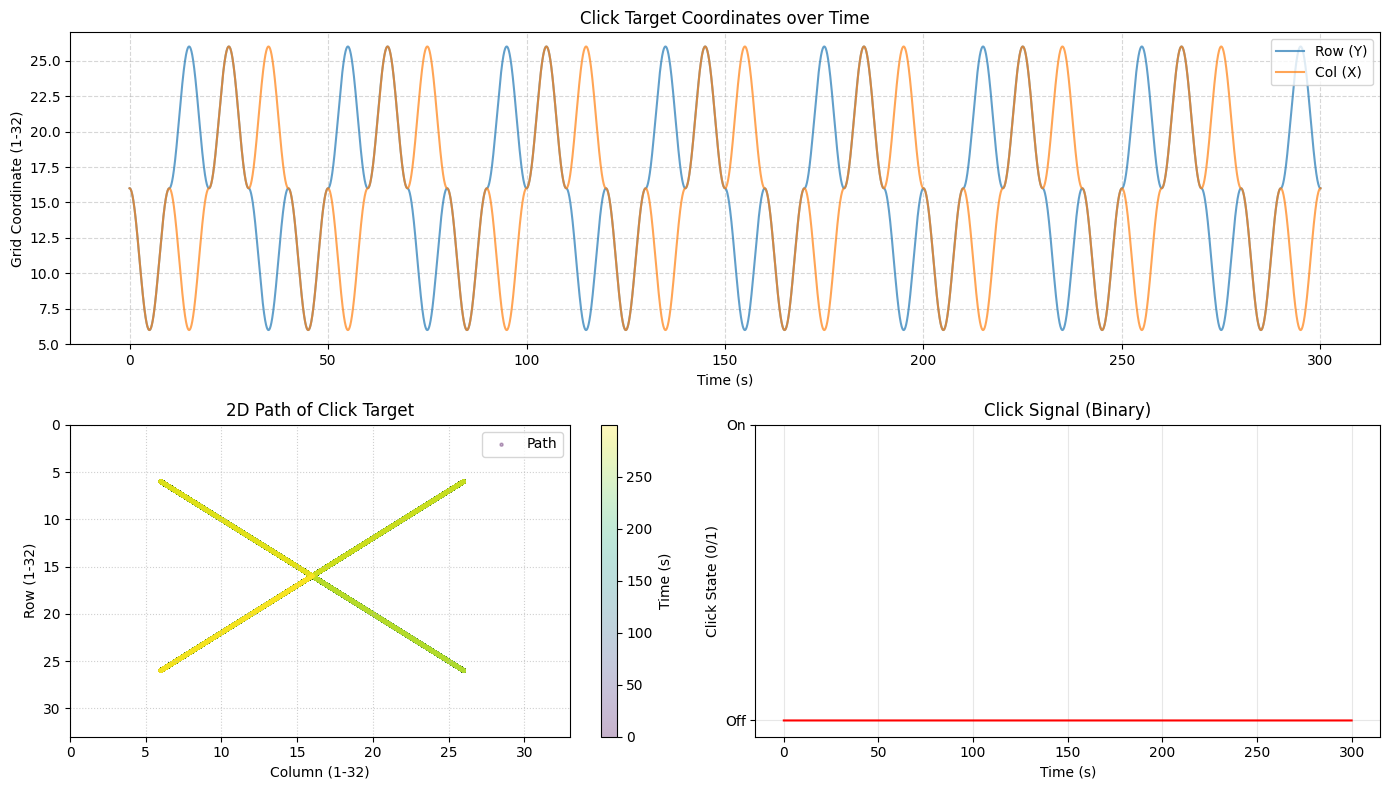

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_click_trajectory(df):
    """
    Visualizes the trajectory of the click target and highlights 
    active click events.
    """
    # Check if necessary columns exist
    required_cols = ['click_center_row', 'click_center_col', 'click', 'time_s']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Dataframe must contain {required_cols}")
        return

    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2)

    # --- Plot A: Row/Col Coordinates over Time ---
    ax_time = fig.add_subplot(gs[0, :])
    ax_time.plot(df['time_s'], df['click_center_row'], label='Row (Y)', color='tab:blue', alpha=0.7)
    ax_time.plot(df['time_s'], df['click_center_col'], label='Col (X)', color='tab:orange', alpha=0.7)
    
    # Highlight times when click == True
    clicks = df[df['click'] == True]
    if not clicks.empty:
        ax_time.scatter(clicks['time_s'], clicks['click_center_row'], 
                        color='red', s=10, label='Click Active (Row)', zorder=5)
        
    ax_time.set_title("Click Target Coordinates over Time")
    ax_time.set_xlabel("Time (s)")
    ax_time.set_ylabel("Grid Coordinate (1-32)")
    ax_time.legend(loc='upper right')
    ax_time.grid(True, linestyle='--', alpha=0.5)

    # --- Plot B: 2D Trajectory (Map) ---
    ax_map = fig.add_subplot(gs[1, 0])
    
    # Plot the full path
    sc = ax_map.scatter(df['click_center_col'], df['click_center_row'], 
                        c=df['time_s'], cmap='viridis', s=5, alpha=0.3, label='Path')
    
    # Overlay the active clicks in Red
    if not clicks.empty:
        ax_map.scatter(clicks['click_center_col'], clicks['click_center_row'], 
                       color='red', s=50, marker='x', label='Click Event')

    ax_map.set_title("2D Path of Click Target")
    ax_map.set_xlabel("Column (1-32)")
    ax_map.set_ylabel("Row (1-32)")
    ax_map.set_xlim(0, 33)
    ax_map.set_ylim(33, 0) # Inverted Y to match grid layout
    ax_map.grid(True, linestyle=':', alpha=0.6)
    ax_map.legend(loc='upper right')
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax_map)
    cbar.set_label('Time (s)')

    # --- Plot C: Click Status (Binary) ---
    ax_status = fig.add_subplot(gs[1, 1])
    ax_status.plot(df['time_s'], df['click'].astype(int), color='red', drawstyle='steps-post')
    ax_status.set_title("Click Signal (Binary)")
    ax_status.set_xlabel("Time (s)")
    ax_status.set_ylabel("Click State (0/1)")
    ax_status.set_yticks([0, 1])
    ax_status.set_yticklabels(['Off', 'On'])
    ax_status.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_click_trajectory(easy_move)

In [131]:
easy_move

,time_s,vx,vy,click,phase,vx_pos_center_row,vx_pos_center_col,vx_neg_center_row,vx_neg_center_col,vy_pos_center_row,vy_pos_center_col,vy_neg_center_row,vy_neg_center_col,click_center_row,click_center_col,pos_x,pos_y,speed
0,0.000,0.804830,2.251354,False,to_to_corn,16.000000,22.000000,16.000000,10.000000,10.000000,16.000000,22.000000,16.000000,16.000000,16.000000,0.000000,0.000000,2.390888
1,0.002,10.284825,-5.853459,False,to_to_corn,15.999996,21.999996,15.999996,9.999996,9.999996,15.999996,21.999996,15.999996,15.999996,15.999996,0.020570,-0.011707,11.833876
2,0.004,6.745677,0.383770,False,to_to_corn,15.999984,21.999984,15.999984,9.999984,9.999984,15.999984,21.999984,15.999984,15.999984,15.999984,0.034061,-0.010939,6.756585
3,0.006,12.578807,-0.049672,False,to_to_corn,15.999964,21.999964,15.999964,9.999964,9.999964,15.999964,21.999964,15.999964,15.999964,15.999964,0.059219,-0.011039,12.578905
4,0.008,13.560429,2.639369,False,to_to_corn,15.999937,21.999937,15.999937,9.999937,9.999937,15.999937,21.999937,15.999937,15.999937,15.999937,0.086339,-0.005760,13.814901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,299.990,60.126537,20.074976,False,from_from_,16.000063,21.999937,16.000063,9.999937,10.000063,15.999937,22.000063,15.999937,16.000063,15.999937,23.909505,-39.173943,63.389313
149996,299.992,57.965981,20.189215,False,from_from_,16.000036,21.999964,16.000036,9.999964,10.000036,15.999964,22.000036,15.999964,16.000036,15.999964,24.025437,-39.133564,61.381264
149997,299.994,59.910942,24.015211,False,from_from_,16.000016,21.999984,16.000016,9.999984,10.000016,15.999984,22.000016,15.999984,16.000016,15.999984,24.145259,-39.085534,64.544952
149998,299.996,62.331383,19.602821,False,from_from_,16.000004,21.999996,16.000004,9.999996,10.000004,15.999996,22.000004,15.999996,16.000004,15.999996,24.269922,-39.046328,65.341194


In [121]:
def get_new_center(df):
    """
    Extracts the X (column) and Y (row) trajectory components.
    """
    x_move = round(df['click_center_col']-16)+50
    y_move = round(df['click_center_row']-16)+50
    return x_move, y_move
def translate_idx_to_centered_xy(idx):
    """
    Translates a flattened index (0-1023) to centered x, y coordinates.
    Assumes a 32x32 grid where 0 maps to roughly -16.
    """
    # 32 columns in the grid
    col = idx % 32
    row = idx // 32
    
    # Center by subtracting 16 (matches your previous logic)
    # Range: -16 to 15
    x_rel = col - 16
    y_rel = row - 16
    
    return x_rel, y_rel



In [122]:
x_new, y_new = get_new_center(easy_move)
# Usage with a single integer
x, y = translate_idx_to_centered_xy(0)    # Returns (-16, -16)
x2, y2 = translate_idx_to_centered_xy(1023) # Returns (15, 15)

# Usage with a pandas Series
# df['rel_x'], df['rel_y'] = translate_idx_to_centered_xy(df['your_index_column'])

In [ ]:
import numpy as np
import pandas as pd

def get_frame_at_time(t_idx, data_df, center_x_series, center_y_series, canvas_size=(100, 100)):
    """
    Places channel values onto a generic canvas based on the center coordinates.
    
    Parameters:
    - t_idx: The integer index (time step) to reconstruct.
    - data_df: The dataframe containing channel data (0-1023).
    - center_x_series, center_y_series: The new center coordinates (x_new, y_new).
    - canvas_size: Tuple (height, width) of the output grid.
    
    Returns:
    - A 2D numpy array representing the spatial neural activity at that moment.
    """
    
    # 1. Create Relative Offsets for Channels 0-1023
    # ------------------------------------------------
    # Create an array of indices [0, 1, ..., 1023]
    indices = np.arange(1024)
    
    # Calculate relative (x, y) assuming 32 columns per row
    # 0 -> (-16, -16), 1023 -> (15, 15)
    rel_x = (indices % 32) - 16
    rel_y = (indices // 32) - 16

    # 2. Get Absolute Coordinates for this Time Step
    # ----------------------------------------------
    # Get center for the specific time index (ensure it's an integer)
    cx = int(center_x_series.iloc[t_idx])
    cy = int(center_y_series.iloc[t_idx])
    
    # Broadcast center to all channels
    abs_x = rel_x + cx
    abs_y = rel_y + cy
    
    # 3. Retrieve Channel Values
    # --------------------------
    # Get the row of data values (1024 amplitudes)
    values = data_df.iloc[t_idx].values
    
    # 4. Map to Canvas
    # ----------------
    canvas = np.zeros(canvas_size)
    height, width = canvas_size
    
    # Filter points that are inside the canvas boundaries
    valid_mask = (abs_x >= 0) & (abs_x < width) & \
                 (abs_y >= 0) & (abs_y < height)
                 
    # Assign values to the grid
    # Note: numpy uses [row, col] which corresponds to [y, x]
    # We use abs_y for rows and abs_x for columns
    canvas[abs_y[valid_mask], abs_x[valid_mask]] = values[valid_mask]
    
    return canvas

# --- Usage Example ---

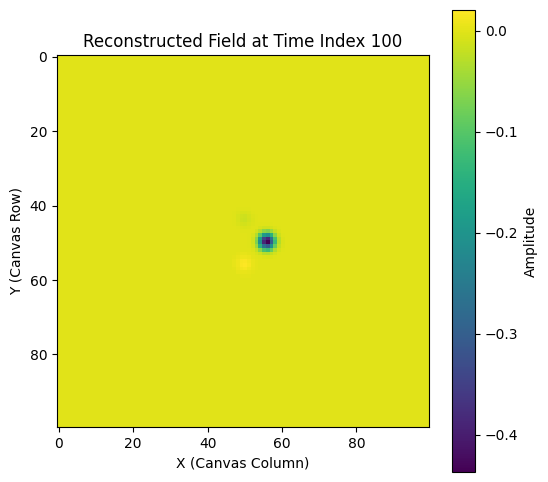

In [134]:
# 1. Pick a time point (e.g., index 100)
t_index = 100

# 2. Generate the frame
# ensuring x_new/y_new are passed correctly (they might be Series or arrays)
frame = get_frame_at_time(t_index, easy_data, x_new, y_new)

# 3. Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(frame, cmap='viridis', origin='upper') # origin='upper' matches matrix coordinates
plt.colorbar(label='Amplitude')
plt.title(f"Reconstructed Field at Time Index {t_index}")
plt.xlabel("X (Canvas Column)")
plt.ylabel("Y (Canvas Row)")
plt.grid(False)
plt.show()

Processing 150000 time points...


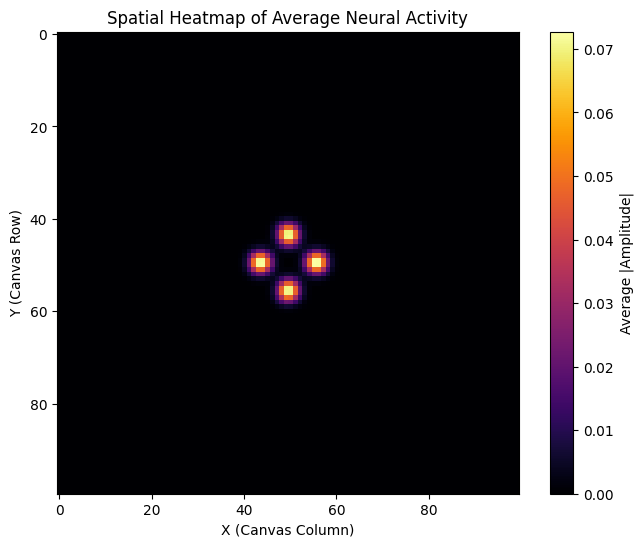

In [137]:
import numpy as np

def get_average_activity_map(data_df, center_x_series, center_y_series, canvas_size=(100, 100)):
    """
    Aggregates the absolute values of all channels over all time points onto a single canvas.
    Returns the average absolute activity per pixel.
    """
    # Initialize accumulators
    accumulation_grid = np.zeros(canvas_size)
    count_grid = np.zeros(canvas_size)  # To track how many times a pixel was visited
    
    height, width = canvas_size
    n_timepoints = len(data_df)
    
    # Pre-calculate relative offsets for channels 0-1023
    indices = np.arange(1024)
    rel_x = (indices % 32) - 16
    rel_y = (indices // 32) - 16
    
    print(f"Processing {n_timepoints} time points...")
    
    # Iterate through all time points
    for t_idx in range(n_timepoints):
        # 1. Get centers
        cx = int(center_x_series.iloc[t_idx])
        cy = int(center_y_series.iloc[t_idx])
        
        # 2. Calculate absolute positions
        abs_x = rel_x + cx
        abs_y = rel_y + cy
        
        # 3. Get absolute values of data
        values = np.abs(data_df.iloc[t_idx].values)
        
        # 4. Filter valid points inside canvas
        valid_mask = (abs_x >= 0) & (abs_x < width) & \
                     (abs_y >= 0) & (abs_y < height)
        
        valid_x = abs_x[valid_mask]
        valid_y = abs_y[valid_mask]
        valid_vals = values[valid_mask]
        
        # 5. Accumulate
        # We use np.add.at because multiple channels might map to the same pixel
        # It's safer for overlapping indices.
        np.add.at(accumulation_grid, (valid_y, valid_x), valid_vals)
        np.add.at(count_grid, (valid_y, valid_x), 1)

    # Avoid division by zero
    # Where count is 0, average remains 0
    average_grid = np.divide(accumulation_grid, count_grid, 
                             out=np.zeros_like(accumulation_grid), 
                             where=count_grid!=0)
    
    return average_grid

# --- Usage ---
avg_map = get_average_activity_map(easy_data, x_new, y_new)

# --- Visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(avg_map, cmap='inferno', origin='upper')
plt.colorbar(label='Average |Amplitude|')
plt.title("Spatial Heatmap of Average Neural Activity")
plt.xlabel("X (Canvas Column)")
plt.ylabel("Y (Canvas Row)")
plt.show()

Processing 150000 time points...


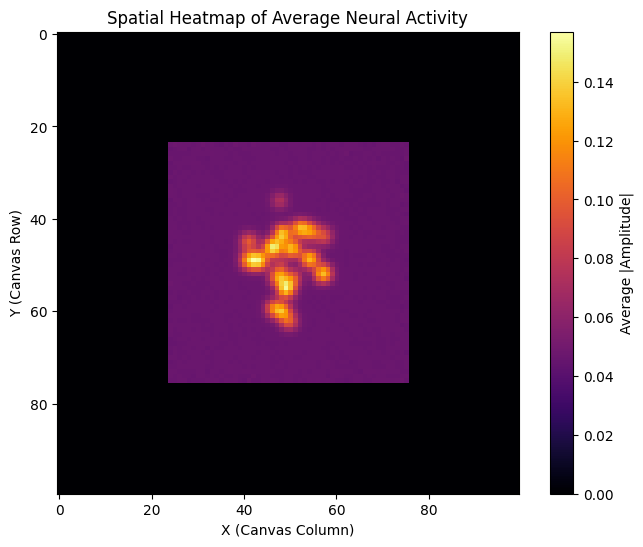

In [144]:
# --- Usage ---
avg_map = get_average_activity_map(med_data, x_new, y_new)

# --- Visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(avg_map, cmap='inferno', origin='upper')
plt.colorbar(label='Average |Amplitude|')
plt.title("Spatial Heatmap of Average Neural Activity")
plt.xlabel("X (Canvas Column)")
plt.ylabel("Y (Canvas Row)")
plt.show()

In [140]:

def preprocess_signals(df, fs=500):
    """
    Applies Notch Filter (60Hz), Common Average Reference (CAR), and Linear Detrending.
    """
    # 1. Notch Filter (60 Hz)
    # Q=30 concentrates the filter narrowly around 60Hz to preserve other data
    b, a = signal.iirnotch(w0=60.0, Q=30.0, fs=fs)
    # filtfilt applies the filter forward and backward (zero-phase distortion)
    filtered_matrix = signal.filtfilt(b, a, df.values, axis=0)
    
    # Rebuild DataFrame to keep indices/columns safe
    df_clean = pd.DataFrame(filtered_matrix, index=df.index, columns=df.columns)

    # 2. Common Average Reference (CAR)
    # Subtract the average of all channels from every channel at each timepoint
    #df_clean = df_clean.sub(df_clean.mean(axis=1), axis=0)

    # 3. Detrend
    # Remove linear trend from each channel
    # comment for now since it is not very important rn
    # df_clean[:] = signal.detrend(df_clean.values, axis=0, type='linear')
    
    return df_clean

from scipy.signal import butter, sosfiltfilt
import pandas as pd

def bandpass_filter(data, lowcut, highcut, fs=500, order=4):
    """
    Apply bandpass filter and return a DataFrame with original index/columns.
    """
    # 1. Design filter
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    
    # 2. Apply filter (returns a numpy array)
    filtered_array = sosfiltfilt(sos, data.values, axis=0)
    
    # 3. Reconstruct DataFrame
    return pd.DataFrame(
        filtered_array, 
        index=data.index, 
        columns=data.columns
    )

    
hard_data_clean = preprocess_signals(hard_data)
hard_data_clean_70_150_no_car = bandpass_filter(hard_data_clean, lowcut=70, highcut=150)


Processing 150000 time points...


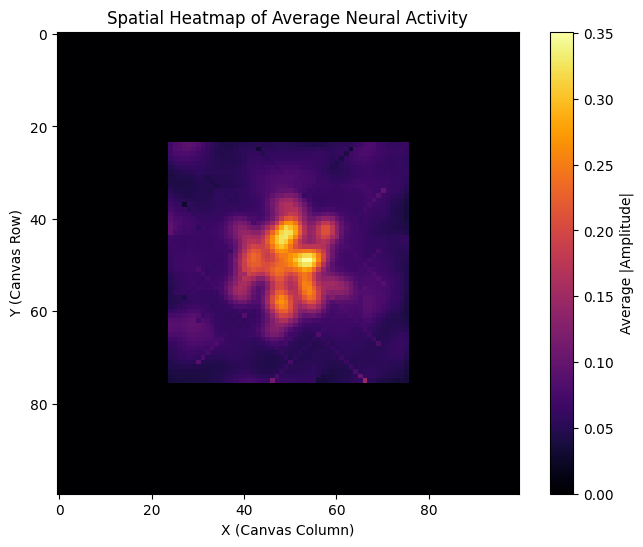

In [141]:
# --- Usage ---
avg_map = get_average_activity_map(hard_data_clean_70_150_no_car, x_new, y_new)

# --- Visualization ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(avg_map, cmap='inferno', origin='upper')
plt.colorbar(label='Average |Amplitude|')
plt.title("Spatial Heatmap of Average Neural Activity")
plt.xlabel("X (Canvas Column)")
plt.ylabel("Y (Canvas Row)")
plt.show()

In [145]:
easy_move

,time_s,vx,vy,click,phase,vx_pos_center_row,vx_pos_center_col,vx_neg_center_row,vx_neg_center_col,vy_pos_center_row,vy_pos_center_col,vy_neg_center_row,vy_neg_center_col,click_center_row,click_center_col
0,0.000,0.804830,2.251354,False,to_to_corn,16.000000,22.000000,16.000000,10.000000,10.000000,16.000000,22.000000,16.000000,16.000000,16.000000
1,0.002,10.284825,-5.853459,False,to_to_corn,15.999996,21.999996,15.999996,9.999996,9.999996,15.999996,21.999996,15.999996,15.999996,15.999996
2,0.004,6.745677,0.383770,False,to_to_corn,15.999984,21.999984,15.999984,9.999984,9.999984,15.999984,21.999984,15.999984,15.999984,15.999984
3,0.006,12.578807,-0.049672,False,to_to_corn,15.999964,21.999964,15.999964,9.999964,9.999964,15.999964,21.999964,15.999964,15.999964,15.999964
4,0.008,13.560429,2.639369,False,to_to_corn,15.999937,21.999937,15.999937,9.999937,9.999937,15.999937,21.999937,15.999937,15.999937,15.999937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,299.990,60.126537,20.074976,False,from_from_,16.000063,21.999937,16.000063,9.999937,10.000063,15.999937,22.000063,15.999937,16.000063,15.999937
149996,299.992,57.965981,20.189215,False,from_from_,16.000036,21.999964,16.000036,9.999964,10.000036,15.999964,22.000036,15.999964,16.000036,15.999964
149997,299.994,59.910942,24.015211,False,from_from_,16.000016,21.999984,16.000016,9.999984,10.000016,15.999984,22.000016,15.999984,16.000016,15.999984
149998,299.996,62.331383,19.602821,False,from_from_,16.000004,21.999996,16.000004,9.999996,10.000004,15.999996,22.000004,15.999996,16.000004,15.999996


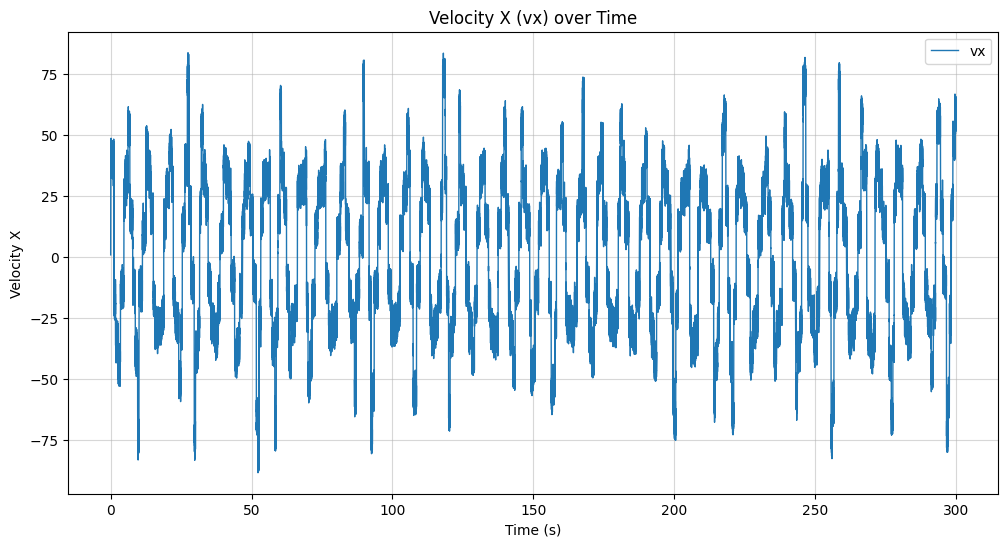

In [146]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(easy_move['time_s'], easy_move['vx'], label='vx', linewidth=1)
plt.title("Velocity X (vx) over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity X")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

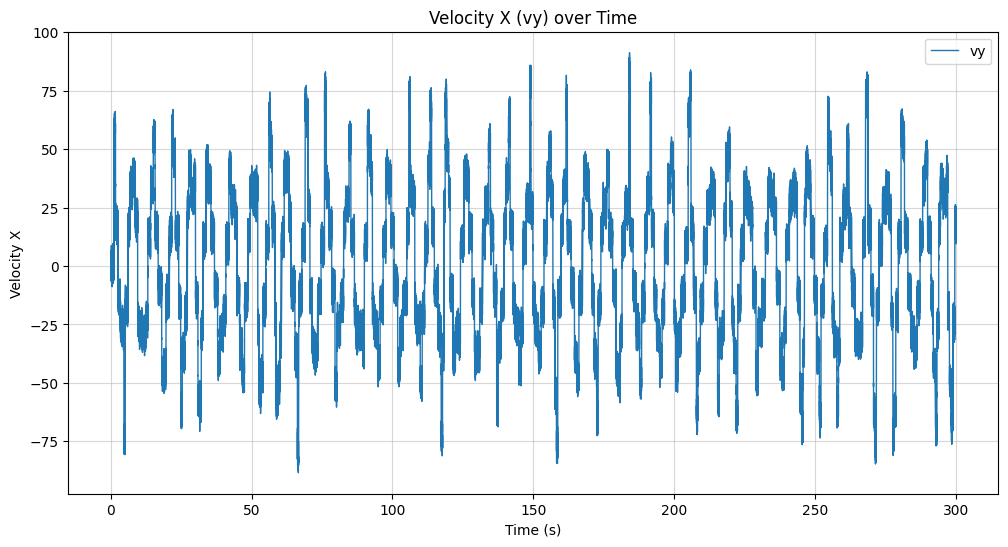

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(easy_move['time_s'], easy_move['vy'], label='vy', linewidth=1)
plt.title("Velocity X (vy) over Time")
plt.xlabel("Time (s)")
plt.ylabel("Velocity X")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()